In [27]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path+'/correlation_enrichment/' not in sys.path:
    sys.path.insert(0,module_path+'/correlation_enrichment/')
if module_path+'/networks/' not in sys.path:
    sys.path.insert(0,module_path+'/networks/')
if module_path+'/data_expression/' not in sys.path:
    sys.path.insert(0,module_path+'/data_expression/')
from scipy import spatial

import altair as alt
alt.renderers.enable('notebook')


from functionsDENet import *
from library import SimilarityCalculator

In [28]:
#Load data, use AX4 average for testing
dataPath=module_path+'/data_expression/'

tableLayout = dict()
tableLayout['rep'] = dict()
tableLayout['single'] = dict()
tableLayout['single']['lastGene'] = 12734
tableLayout['single']['Time'] = 12737
tableLayout['single']['Strain'] = 12736
tableLayout['rep']['lastGene'] = 12868
tableLayout['rep']['Time'] = 12870
tableLayout['rep']['Strain'] = 12869
# data=tableLayout['single']
data = tableLayout['rep']

samples = {
    'AX4': [1, 2, 5, 6, 7, 8, 9],
    'tagB': [1, 2],
    'comH': [1, 2],
    'tgrC1': [1, 2],
    'tgrB1': [1, 2],
    'tgrB1C1': [1, 2],
    'gbfA': [1, 2],
}

genesFromRow = 2

strain = 'AX4'

table = importTable(dataPath + 'trans_9repAX4_6strains_2rep_avr_T12.tab')
genes, genesNotNull = extractGenesFromTable(table, genesFromRow, data['lastGene'])

# For average of strain
genesWT, genesWTN = genesByStrain(genesNotNull, table, data['Strain'], strain + '_avr', genesFromRow)

## Check if cosine metric corresponds to "hand-calculated" cosine distance

In [22]:
# Perform KNN with package
knnNeighbours=30
dist, neigh, distInv, neighInv, nGenesKnnUsed = genesKNN(knnNeighbours, genesWTN, 1, save=False, timing=True)

# Check cosine distance calculation
scaled = normaliseGenes(genesWTN, 1)
inverse = scaled * -1
sse = []
sse_inv = []
for gene in range(0, 150):
    for neighbour in range(1, knnNeighbours):
        cosine_package = round(dist[gene][neighbour], 7)
        cosine_direct = round(spatial.distance.cosine(scaled[gene], scaled[neigh[gene][neighbour]]), 7)
        sse.append((cosine_direct - cosine_package) ** 2)
    for neighbour in range(0, knnNeighbours):
        cosine_package = round(distInv[gene][neighbour], 7)
        cosine_direct = round(1-SimilarityCalculator.calc_cosine(inverse[gene], scaled[neighInv[gene][neighbour]]), 7)
        sse_inv.append((cosine_direct - cosine_package) ** 2)
print('MSE', sum(sse) / len(sse))
print('MSE inverse', sum(sse_inv) / len(sse_inv))



Index sec: 1.3025460243225098
KNN 30 sec: 2.363718271255493
KNN 30 inverse sec: 1.6984362602233887
MSE 1.2850574712743311e-15
MSE inverse 1.0066666666736874e-15


In [ ]:
# Check if closest neighbours computation is reliable
# Check how this depends on data set size and number of required neighbours
subset_size = []
neighbour_n = []
mean_diff = []
mean_diff_inv = []
for subset in [100, 500, 1000]:
    genesSub = genesWTN.iloc[:subset, ]

    # Compute all similarities by hand
    similarities = np.ones((subset, subset))
    scaled = normaliseGenes(genesSub, 1)
    for i in range(0, subset - 1):
        for j in range(i + 1, subset):
            similarity = SimilarityCalculator.calc_cosine(scaled[i], scaled[j])
            similarities[j][i] = similarity
            similarities[i][j] = similarity
            
    # If knnNeighbours is set too big compared to sample size the package becomes very slow
    for knnNeighbours in [3, 5, 8, int(subset / 10), int(subset / 5)]:
        print(subset, knnNeighbours)
        subset_size.append(subset)
        neighbour_n.append(knnNeighbours)

        # Neighbours with package
        dist, neigh, distInv, neighInv, nGenesKnnUsed = genesKNN(knnNeighbours, genesSub, 1, save=False, timing=True)

        # Check if neighbours are the same
        # For each gene sum differences of knn best neighbour position indices between approximated neighbours
        # and all neighbours computed based on computing all distances. For each set of parameters average these 
        # differences for closest neighbours and "inverse" neighbours (eg. opposite profile).
        place_inv = list(range(0, subset))
        diffs_inv = []
        diffs = []
        for i in range(0, subset):
            sorted_indices = np.argsort(similarities[i])
            neigh_dict_inv = dict(zip(sorted_indices, place_inv))
            diff = 0
            diff_inv = 0
            for neighbour_place in range(knnNeighbours):
                neighbour_inv = neighInv[i][neighbour_place]
                real_place_inv = neigh_dict_inv[neighbour_inv]
                diff_inv += abs(real_place_inv - neighbour_place)

                # Note that closest neighbour is most often self, but not always.
                # Thus the first neighbour is not automatically excluded
                real_place = subset - 1 - neigh_dict_inv[neighbour]
                neighbour = neigh[i][neighbour_place]
                diff += abs(real_place - neighbour_place)
            diffs.append(diff)
            diffs_inv.append(diff_inv)

        mean_diff.append(mean(diffs))
        mean_diff_inv.append(mean(diffs_inv))

In [36]:
df = pd.DataFrame(list(zip(subset_size, neighbour_n, mean_diff, mean_diff_inv)),
                  columns=['N genes', 'N neighbours', 'mean neighbour diff', 'mean inverse neighbour diff'])

On the below graphs "mean neighbour diff" is average of difference sums between true neighbour positions and approximated ones for each gene for approximated neighbours.

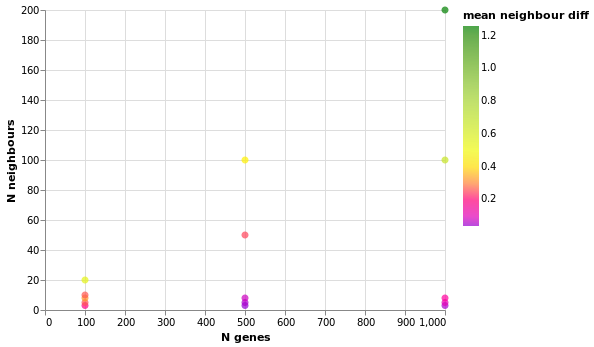

In [39]:
alt.Chart(df).mark_circle().encode(x='N genes',y='N neighbours', 
                                   color=alt.Color('mean neighbour diff',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_circle(size=50)

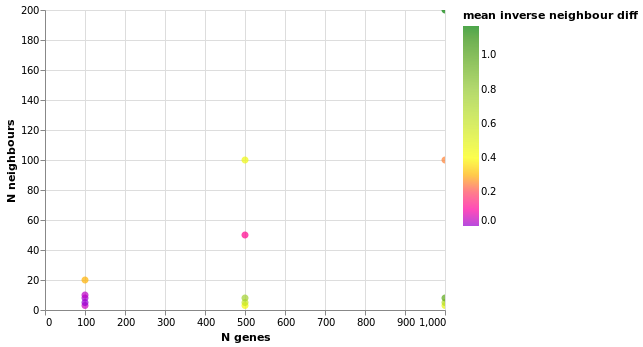

In [38]:
alt.Chart(df).mark_circle().encode(x='N genes', y='N neighbours',
                                   color=alt.Color('mean inverse neighbour diff', scale=
                                   alt.Scale(range=['darkviolet', 'yellow', 'yellowgreen', 'green']))
                                   ).configure_circle(size=50).interactive()